In [1]:
import pandas as pd
import numpy as np
import torch 
%matplotlib inline
import math
import scipy.stats
import time
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [2]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [4]:
train=pd.read_feather('J:/quant_trade/train.feather')
test=pd.read_feather('J:/quant_trade/test.feather')
tlist=train.columns.tolist()
tlist=tlist[4:104]

In [5]:
x_train=train[tlist]
y_train=train['1W']
x_test=test[tlist]
y_test=test['1W']

In [24]:
y_test.describe()

count    998429.000000
mean          0.005463
std           0.070965
min          -0.643727
25%          -0.032663
50%           0.000000
75%           0.035000
max           1.488540
Name: 1W, dtype: float64

In [5]:
scale=StandardScaler()
x_train_s=scale.fit_transform(x_train)
x_test_s=scale.fit_transform(x_test)

In [6]:
train_xt=torch.from_numpy(x_train.values.astype(np.float32)).cuda()
train_yt=torch.from_numpy(y_train.values.astype(np.float32)).cuda()
test_xt=torch.from_numpy(x_test.values.astype(np.float32)).cuda()
test_yt=torch.from_numpy(y_test.values.astype(np.float32)).cpu()

In [7]:
train=None
test=None
x_train=None
y_train=None
x_test=None
y_test=None

In [7]:
train_data=Data.TensorDataset(train_xt,train_yt)
test_data=Data.TensorDataset(test_xt,test_yt)

In [25]:
class MLPrg(nn.Module):
    def __init__(self):
        super(MLPrg,self).__init__()
        self.hidden1=nn.Linear(in_features=100,out_features=512,bias=True)
        self.hidden2=nn.Linear(in_features=512,out_features=256)
        self.hidden3=nn.Linear(in_features=256,out_features=128)
        self.hidden4=nn.Linear(in_features=128,out_features=64)
        self.predict=nn.Linear(64,1)
    def forward(self,x):
        x=F.tanh(self.hidden1(x))
        x=F.tanh(self.hidden2(x))
        x=F.tanh(self.hidden3(x))
        x=F.tanh(self.hidden4(x))
        output=self.predict(x)
        return output[:,0]
rg=MLPrg()
rg=rg.cuda()
loss_func=nn.L1Loss(reduction='mean')
loss_func=loss_func.cuda()
train_loss_all=[]
maslist=[]
plt.figure(figsize=(10,6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [26]:
train_loader=Data.DataLoader(dataset=train_data,batch_size=256,shuffle=True,num_workers=0)
for step,(b_x,b_y) in enumerate(train_loader):
    if step>0:
        break

In [27]:
optimizer=torch.optim.Adam(rg.parameters(),lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [2]:
timer = Timer()
for epoch in range(100):
    train_loss=0
    train_num=0
    print(epoch)
    for step,(b_x,b_y) in enumerate(train_loader):
        b_x=b_x.cuda()
        b_y=b_y.cuda()
        output=rg(b_x)
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*b_x.size(0)
        train_num+=b_x.size(0)
    scheduler.step()
    train_loss_all.append(train_loss/train_num)
    testy=rg(test_xt)
    testy=testy.cpu()
    mae=mean_absolute_error(test_yt.detach().numpy(),testy.detach().numpy())
    maslist.append(mae)
    plt.plot(train_loss_all,'ro-',label='trainloss')
    plt.plot(maslist,'bo-',label='mas')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch',size=13)
    plt.ylabel('epoch',size=13)
    plt.show()
    print(train_loss_all)
    print(maslist)
f'{timer.stop():.5f} sec'

NameError: name 'Timer' is not defined

In [37]:
torch.save(rg,'J:/quant_trade/modelbase/temp.pt')

In [39]:
df=pd.DataFrame()
df['time']=test['trade_date']
df['real']=test_yt
df['pre']=testy.detach().numpy()
df.set_index('time',inplace=True)
scipy.stats.ks_2samp(df['pre'],df['real'])

KstestResult(statistic=0.4067610215648784, pvalue=0.0, statistic_location=-0.009776493, statistic_sign=-1)

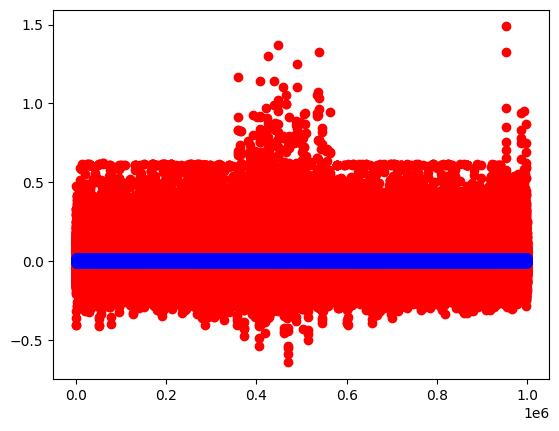

In [40]:
plt.scatter(y=df['real'],x=range(df.shape[0]),color='r')
plt.scatter(y=df['pre'],x=range(df.shape[0]),color='b')

(array([  7338., 105395., 252984., 239894., 133490., 115918.,  69160.,
         49358.,  24349.,    543.]),
 array([-0.01321393, -0.00981349, -0.00641306, -0.00301263,  0.0003878 ,
         0.00378824,  0.00718867,  0.0105891 ,  0.01398953,  0.01738997,
         0.0207904 ], dtype=float32),
 <BarContainer object of 10 artists>)

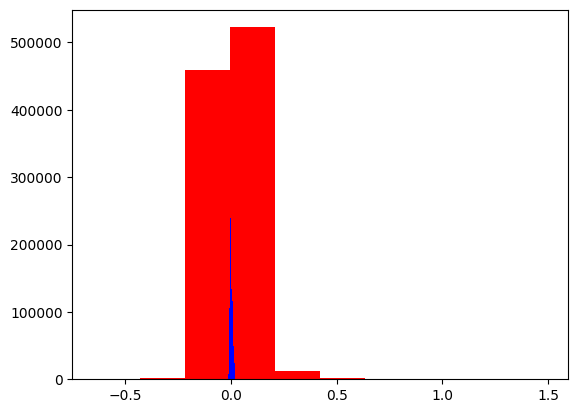

In [41]:
plt.hist(df['real'],color='r')
plt.hist(df['pre'],color='b')

In [1]:
df['real'].describe()

NameError: name 'df' is not defined

In [ ]:
df[['real','pre']].plot()